In [1]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load TensorBoard
%load_ext tensorboard

In [2]:
# Convert from 64 to 32 bit floats
X_test = np.load("../data/X_test.npy").astype(np.float32)
y_test = np.load("../data/y_test.npy").astype(np.float32)
person_train_valid = np.load("../data/person_train_valid.npy").astype(np.float32)
X_train_valid = np.load("../data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("../data/y_train_valid.npy").astype(np.float32)
person_test = np.load("../data/person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


## Data Augmentation
Generate two copies, one with filtering from 8-13Hz (mu band) and another 13-30Hz (beta band)

"I found a paper where they use a 5th order butterworth filter to extract the mu band (8-13Hz) and the beta band (13-30Hz), which correspond to ERD and ERS (Event-related desynchronization and event-related synchronization) (don't ask me what those mean.) The paper trains a model with our data. Just throwing this out there."

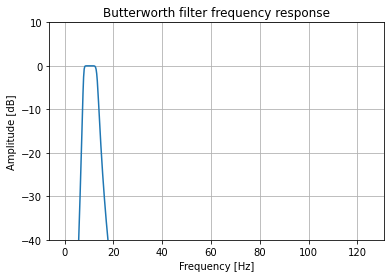

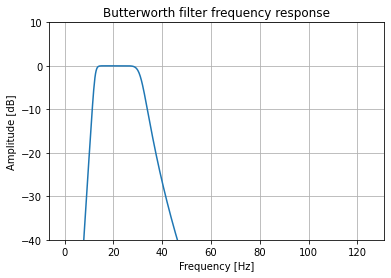

In [3]:
n, wn = signal.buttord(wp=[8, 13], ws=[6, 18], fs=250, gpass=1, gstop=36)
sos1 = signal.butter(n, wn, btype='bandpass', fs=250, output='sos')
w, h = signal.sosfreqz(sos1, fs=250)
# Stolen from scipy docs thanks guys
plt.plot(w, 20 * np.log10(abs(h) + 1e-15))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.ylim(-40, 10)
plt.grid(which='both', axis='both')
plt.show()

n, wn = signal.buttord(wp=[13, 30], ws=[8, 48], fs=250, gpass=1, gstop=36)
sos2 = signal.butter(n, wn, btype='bandpass', fs=250, output='sos')
w, h = signal.sosfreqz(sos2, fs=250)
plt.plot(w, 20 * np.log10(abs(h) + 1e-15))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.ylim(-40, 10)
plt.grid(which='both', axis='both')
plt.show()

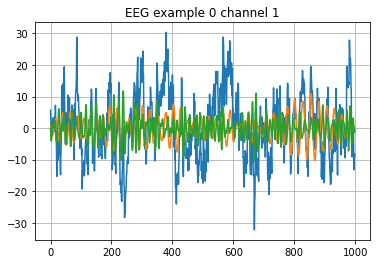

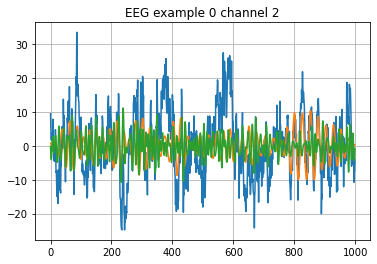

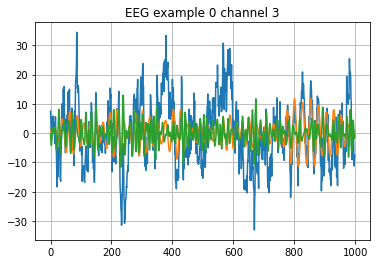

(2115, 22, 1000) -> (2115, 66, 1000)
(2115,) -> (2115,)
(443, 22, 1000) -> (443, 66, 1000)
(443,) -> (443,)


In [23]:
X_train_valid_filtered_1 = signal.sosfiltfilt(sos1, X_train_valid, axis=-1)
X_train_valid_filtered_2 = signal.sosfiltfilt(sos2, X_train_valid, axis=-1)
X_test_filtered_1 = signal.sosfiltfilt(sos1, X_test, axis=-1)
X_test_filtered_2 = signal.sosfiltfilt(sos2, X_test, axis=-1)

for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.plot(X_train_valid_filtered_1[0,i,:])
    plt.plot(X_train_valid_filtered_2[0,i,:])
    plt.grid()
    plt.show()

# Concatenate filtered channels with source samples
X_train_valid_aug = np.concatenate(
    (X_train_valid, X_train_valid_filtered_1, X_train_valid_filtered_2), axis=1)
y_train_valid_aug = y_train_valid
X_test_aug = np.concatenate(
    (X_test, X_test_filtered_1, X_test_filtered_2), axis=1)
y_test_aug = y_test
print(X_train_valid.shape, "->", X_train_valid_aug.shape)
print(y_train_valid.shape, "->", y_train_valid_aug.shape)
print(X_test.shape, "->", X_test_aug.shape)
print(y_test.shape, "->", y_test_aug.shape)

# Convert to TensorFlow data structure
Reference: https://www.tensorflow.org/tutorials/load_data/numpy

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid_aug, y_train_valid_aug))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_aug, y_test_aug))

print(train_dataset.element_spec)
print(test_dataset.element_spec)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

(TensorSpec(shape=(66, 1000), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
(TensorSpec(shape=(66, 1000), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))


## Model 1
Two convolutional layers, first 1D to get per-channel features, second 2D to combine channel features into time-series.... something. I don't know, but the idea is the second layer combines each channel into time-series filters. One option has the second layer as a ConvLSTM2D with millions of parameters and the other has a Conv2D, average pool, then ConvLSTM2D to reduce the number of paramters dramatically. Both have similar performance as of right now.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_13 (Permute)         (None, 1000, 66)          0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 1000, 66)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1000, 100)         165100    
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1000, 100)         250100    
_________________________________________________________________
average_pooling1d_24 (Averag (None, 200, 100)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 200, 100)          400       
_________________________________________________________________
reshape_33 (Reshape)         (None, 200, 100, 1)     

34/34 [==============================] - 2s 49ms/step - loss: 0.3321 - sparse_categorical_accuracy: 0.8813 - val_loss: 3.3712 - val_sparse_categorical_accuracy: 0.4199
Epoch 33/100
34/34 [==============================] - 2s 49ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9092 - val_loss: 2.8369 - val_sparse_categorical_accuracy: 0.4334
Epoch 34/100
34/34 [==============================] - 2s 48ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9371 - val_loss: 2.6433 - val_sparse_categorical_accuracy: 0.4605
Epoch 35/100
34/34 [==============================] - 2s 49ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9475 - val_loss: 2.7364 - val_sparse_categorical_accuracy: 0.4921
Epoch 36/100
34/34 [==============================] - 2s 50ms/step - loss: 0.2263 - sparse_categorical_accuracy: 0.9173 - val_loss: 3.0698 - val_sparse_categorical_accuracy: 0.4718
Epoch 37/100
34/34 [==============================] - 2s 50ms/step - loss: 0.2046 - sparse_categorical_accur

34/34 [==============================] - 2s 49ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9948 - val_loss: 3.9543 - val_sparse_categorical_accuracy: 0.5056
Epoch 78/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9967 - val_loss: 3.9533 - val_sparse_categorical_accuracy: 0.4966
Epoch 79/100
34/34 [==============================] - 2s 49ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9924 - val_loss: 4.0355 - val_sparse_categorical_accuracy: 0.5079
Epoch 80/100
34/34 [==============================] - 2s 49ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9924 - val_loss: 3.8978 - val_sparse_categorical_accuracy: 0.5237
Epoch 81/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9872 - val_loss: 4.4361 - val_sparse_categorical_accuracy: 0.5079
Epoch 82/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0369 - sparse_categorical_accur

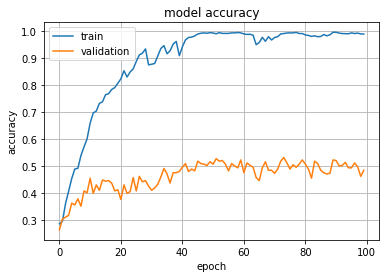

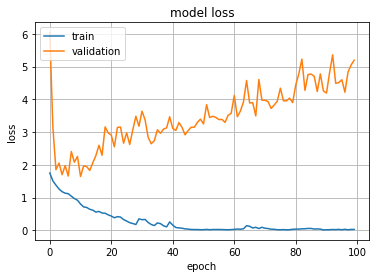

7/7 [==============================] - 0s 20ms/step - loss: 5.1941 - sparse_categorical_accuracy: 0.4853
[5.194127082824707, 0.4853273034095764]


In [19]:
n_ch = 22 * 3 # 22
nfs = [100, 250, 10]
conv_sizes = [25, (10, nfs[0]), (5, nfs[1])]
pool_sizes = [20, 10]
pool_strides = [5, 4]
input_dropout = 0.0
fc_dropout = 0.5

# Model init
model = tf.keras.Sequential()
model.add(layers.Permute((2, 1), input_shape=(n_ch, 1000)))
model.add(layers.Dropout(input_dropout, noise_shape=(1, n_ch)))

# Shape 1 - 1D
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='relu'))
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='relu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[0], strides=pool_strides[0],
    padding='same'))
model.add(layers.BatchNormalization())

# Shape 2 - 2D, option 1 Conv2D then LSTM
model.add(layers.Reshape((1000//pool_strides[0], nfs[0], 1)))
model.add(layers.Conv2D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    activation='relu'))
model.add(layers.Reshape((191, nfs[1])))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[1], strides=pool_strides[1],
    padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Reshape((1, 48, nfs[1], 1)))
# model.add(layers.ConvLSTM2D(
#     filters=nfs[2], kernel_size=conv_sizes[2],
#     activation='relu'))

# Shape 2 - 2D, option 2 with ConvLSTM2D
# model.add(layers.Reshape((1, 200, 44, 1)))
# model.add(layers.ConvLSTM2D(
#     filters=nfs[1], kernel_size=conv_sizes[1],
#     activation='relu'))
# model.add(layers.Reshape((191, 50)))
# # model.add(layers.Dropout(0.5))
# model.add(layers.AveragePooling1D(
#     pool_size=pool_sizes[1], strides=pool_strides[1],
#     padding='same'))
# model.add(layers.BatchNormalization())


# FC layers
model.add(layers.Flatten())
model.add(layers.Dropout(fc_dropout))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_dataset,
    batch_size=128,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

## Model 2
This sticks to 1D layers working on each of the 22 channels, that are combined at the end using FC nets. This has similar performance as Model 1 right now but I think it will not perform as well when data is augmented more appropriately.

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_15 (Permute)         (None, 1000, 66)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1000, 40)          52840     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 1000, 40)          32040     
_________________________________________________________________
average_pooling1d_28 (Averag (None, 100, 40)           0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 100, 40)           160       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 100, 100)          40100     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 100, 100)        

34/34 [==============================] - 1s 33ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8723 - val_loss: 3.3236 - val_sparse_categorical_accuracy: 0.4921
Epoch 36/100
34/34 [==============================] - 1s 33ms/step - loss: 0.4544 - sparse_categorical_accuracy: 0.8473 - val_loss: 2.4260 - val_sparse_categorical_accuracy: 0.5214
Epoch 37/100
34/34 [==============================] - 1s 33ms/step - loss: 0.2543 - sparse_categorical_accuracy: 0.9078 - val_loss: 2.0048 - val_sparse_categorical_accuracy: 0.5463
Epoch 38/100
34/34 [==============================] - 1s 33ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.9541 - val_loss: 2.2571 - val_sparse_categorical_accuracy: 0.5034
Epoch 39/100
34/34 [==============================] - 1s 33ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9381 - val_loss: 1.9089 - val_sparse_categorical_accuracy: 0.5734
Epoch 40/100
34/34 [==============================] - 1s 34ms/step - loss: 0.0743 - sparse_categorical_accur

34/34 [==============================] - 1s 37ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9839 - val_loss: 2.3408 - val_sparse_categorical_accuracy: 0.5598
Epoch 81/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0263 - sparse_categorical_accuracy: 0.9920 - val_loss: 2.1751 - val_sparse_categorical_accuracy: 0.5734
Epoch 82/100
34/34 [==============================] - 1s 37ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9986 - val_loss: 2.1980 - val_sparse_categorical_accuracy: 0.5621
Epoch 83/100
34/34 [==============================] - 1s 37ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9891 - val_loss: 2.7254 - val_sparse_categorical_accuracy: 0.5372
Epoch 84/100
34/34 [==============================] - 1s 38ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9045 - val_loss: 3.3067 - val_sparse_categorical_accuracy: 0.5056
Epoch 85/100
34/34 [==============================] - 1s 35ms/step - loss: 0.1281 - sparse_categorical_accur

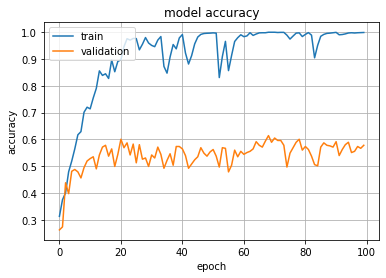

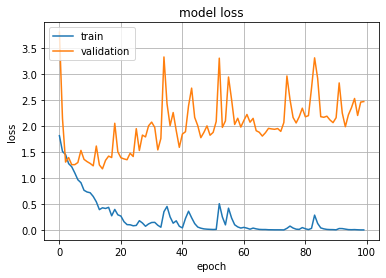

7/7 [==============================] - 0s 19ms/step - loss: 2.4678 - sparse_categorical_accuracy: 0.5779
[2.4678409099578857, 0.5778781175613403]


In [21]:
nfs = (40, 100)
conv_sizes = (20, 10)
pool_sizes = (25, 10)
pool_strides = (10, 4)

# Model init
model = tf.keras.Sequential()
model.add(layers.Permute((2, 1), input_shape=(22 * 3, 1000)))

# Shape 1
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='relu'))
model.add(layers.Conv1D(
    filters=nfs[0], kernel_size=conv_sizes[0],
    padding='same',
    activation='relu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[0], strides=pool_strides[0],
    padding='same'))
model.add(layers.BatchNormalization())

# Shape 2
model.add(layers.Conv1D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    padding='same',
    activation='relu'))
model.add(layers.Conv1D(
    filters=nfs[1], kernel_size=conv_sizes[1],
    padding='same',
    activation='relu'))
model.add(layers.AveragePooling1D(
    pool_size=pool_sizes[1], strides=pool_strides[1],
    padding='same'))
model.add(layers.BatchNormalization())

# FC layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(25, activation='relu'))
# model.add(layers.GRU(25, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_dataset,
    batch_size=128,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
# Old model derived from baseline with early ConvLSTM2D, this one was very weird but had some tricks I wanted to keep around

assert False # Yeah don't run this... is bad

nf = 40
conv_size = 25
n_dense_connections = 40

model = tf.keras.Sequential()
model.add(layers.Reshape((1, 1, 22, 1000), input_shape=(22, 1000)))
model.add(layers.ConvLSTM2D(input_shape=(1, 22, 1000),
                        filters=nf, kernel_size=(1, conv_size),
                        data_format='channels_first',
                        padding='same', activation='relu'))
# model.add(layers.Conv2D(input_shape=(nf, 22, 1000),
#                         filters=nf, kernel_size=(1, conv_size), data_format='channels_first',
#                         padding='same', activation='relu'))
# model.add(layers.Conv2D(input_shape=(nf, 22, 1000),
#                         filters=nf, kernel_size=(1, conv_size), data_format='channels_first',
#                         padding='same', activation='relu'))
# model.add(layers.Permute((1, 4, 2, 3)))
model.add(layers.Permute((3,1,2)))
model.add(layers.Reshape((1000, nf*22)))
model.add(layers.Dropout(0.1, noise_shape=(1, nf*22)))
model.add(layers.Dense(n_dense_connections, kernel_regularizer='l2', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Lambda(lambda x: K.pow(x, 2)))
model.add(layers.AveragePooling1D(input_shape=(1000, nf*22),
                                  pool_size=75, strides=15))
model.add(layers.Lambda(lambda x: K.log(x + 1e-12)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(40, activation='relu', kernel_regularizer='l2'))
model.add(layers.Dense(4, activation='softmax', kernel_regularizer='l2'))

model.summary()

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_dataset,
    batch_size=128,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback]
)

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Evaluate model on test dataset
print(model.evaluate(test_dataset))